<a href="https://colab.research.google.com/github/Tommy840602/XGboost/blob/main/XGBoost_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import skew
from collections import OrderedDict

In [22]:
train_df=pd.read_csv('/content/train.csv', header=0)
test_df=pd.read_csv('/content/test.csv', header=0)

In [23]:
categorical_features=['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities',
                      'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                      'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
                      'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating',
                      'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
                     'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence',
                     'MiscFeature','SaleType','SaleCondition']
every_column_except_y= [col for col in train_df.columns if col not in ['SalePrice','Id']]

In [24]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [25]:
every_column_non_categorical= [col for col in train_df.columns if col not in categorical_features and col not in ['Id'] ]

numeric_feats = train_df[every_column_non_categorical].dtypes[train_df.dtypes != "object"].index

train_df[numeric_feats] = np.log1p(train_df[numeric_feats])

every_column_non_categorical= [col for col in test_df.columns if col not in categorical_features and col not in ['Id'] ]
numeric_feats = test_df[every_column_non_categorical].dtypes[test_df.dtypes != "object"].index
test_df[numeric_feats] = np.log1p(test_df[numeric_feats])

In [26]:
features_with_nan=['Alley','MasVnrType','BsmtQual','BsmtQual','BsmtCond','BsmtCond','BsmtExposure',
                   'BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish']

def ConverNaNToNAString(data, columnList):
    for x in columnList:
        data[x] =str(data[x])

ConverNaNToNAString(train_df, features_with_nan)
ConverNaNToNAString(test_df, features_with_nan)

In [27]:
def CreateColumnPerValue(data, columnList):
    for x in columnList:

        values=pd.unique(data[x])

        for v in values:
            column_name=x+"_"+str(v)
            data[column_name]=(data[x]==v).astype(float)

        data.drop(x, axis=1, inplace=True)

In [28]:
train_df = pd.get_dummies(train_df,columns =categorical_features)
test_df = pd.get_dummies(test_df,columns =categorical_features)

In [29]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
every_column_except_y= [col for col in train_df.columns if col not in ['SalePrice','Id']]
model.fit(train_df[every_column_except_y],train_df['SalePrice'])

OrderedDict(sorted(model.get_booster().get_score().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('LotFrontage', 2502.0),
             ('LotArea', 2482.0),
             ('GarageYrBlt', 2055.0),
             ('BsmtUnfSF', 2010.0),
             ('GrLivArea', 2009.0),
             ('1stFlrSF', 1898.0),
             ('GarageArea', 1854.0),
             ('TotalBsmtSF', 1683.0),
             ('BsmtFinSF1', 1487.0),
             ('WoodDeckSF', 1453.0),
             ('OpenPorchSF', 1451.0),
             ('YearBuilt', 1287.0),
             ('MasVnrArea', 1230.0),
             ('MoSold', 1226.0),
             ('YearRemodAdd', 1146.0),
             ('2ndFlrSF', 1028.0),
             ('YrSold', 779.0),
             ('OverallCond', 610.0),
             ('OverallQual', 592.0),
             ('EnclosedPorch', 534.0),
             ('TotRmsAbvGrd', 531.0),
             ('BsmtFinSF2', 416.0),
             ('ScreenPorch', 388.0),
             ('BedroomAbvGr', 379.0),
             ('Neighborhood_NAmes', 305.0),
             ('BsmtFullBath', 297.0),
             ('Fireplaces', 296.0),
    

In [46]:
most_relevant_features= list( dict((k, v) for k, v in model.get_booster().get_score().items() if v >= 10).keys())
print(most_relevant_features)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_80', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'Neighborhood_Blmngtn', 'Neighborhood_BrkSide', 'Ne

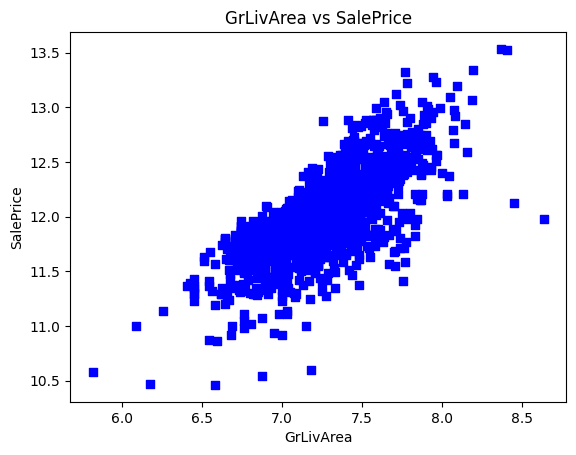

In [32]:
plt.scatter(train_df.GrLivArea, train_df.SalePrice, c = "blue", marker = "s")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

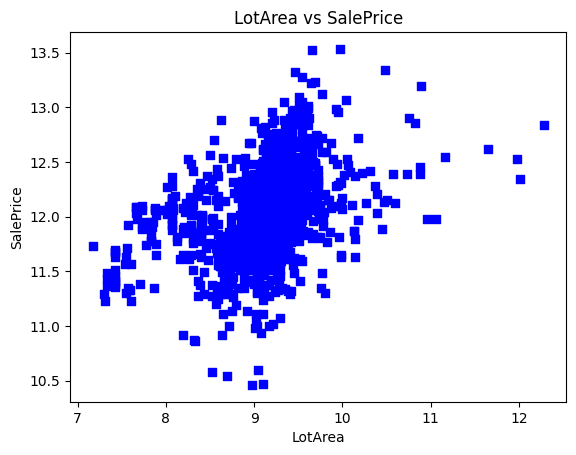

In [33]:
plt.scatter(train_df.LotArea, train_df.SalePrice, c = "blue", marker = "s")
plt.title("LotArea vs SalePrice")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

In [34]:
train_df = train_df[train_df.GrLivArea < 8.25]
train_df = train_df[train_df.LotArea < 11.5]
train_df = train_df[train_df.SalePrice<13]
train_df = train_df[train_df.SalePrice>10.75]
train_df.drop("Id", axis=1, inplace=True)

In [45]:
train_x=train_df[most_relevant_features]
train_y=train_df['SalePrice']

In [47]:
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
best_xgb_model.fit(train_x,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
test_df['Prediction'] = np.expm1(best_xgb_model.predict(test_df[most_relevant_features]))
pd.DataFrame({'Id': test_df.Id, 'SalePrice': test_df.Prediction}).to_csv('submission.csv', index=False)

In [52]:
print(test_df['Prediction'])

0       124504.507812
1       161490.765625
2       188462.718750
3       193368.390625
4       171719.125000
            ...      
1454     80910.421875
1455     83330.953125
1456    176576.531250
1457    112649.859375
1458    205763.687500
Name: Prediction, Length: 1459, dtype: float32
